In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('../Data/cleaned_data.csv')

In [3]:
dataset.head()

,productTitle,title_length,originalPrice,price,sold,tagText,has_free_shipping,price_bin,discount_pct
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,127,110.618189,46.79,600,Free shipping,1,<50,0.58
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,127,352.819724,169.72,0,Free shipping,1,100-200,0.52
2,Desser For Bedroom With 7 Fabric Drawers Organ...,124,78.400000,39.46,7,Free shipping,1,<50,0.50
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",128,239.077801,111.99,0,Free shipping,1,100-200,0.53
4,Small Unit Simple Computer Desk Household Wood...,121,48.820000,21.37,1,Free shipping,1,<50,0.56


In [4]:
 # Convert productTitle into a numeric feature using TF-IDF Vectorizer

 from sklearn.feature_extraction.text import TfidfVectorizer

 tfidf = TfidfVectorizer(max_features=100)
 productTitle_tfidf = tfidf.fit_transform(dataset['productTitle'])

 # Convert to DataFrame and concatenate to original df
 productTitle_tfidf_df = pd.DataFrame(productTitle_tfidf.toarray(),columns=tfidf.get_feature_names_out())
 dataset = pd.concat([dataset, productTitle_tfidf_df], axis=1)

 # Drop original productTitle as it's now encoded
 dataset = dataset.drop('productTitle', axis=1)

In [5]:
dataset.head()

,title_length,originalPrice,price,sold,tagText,has_free_shipping,price_bin,discount_pct,adjustable,and,...,up,upholstered,vanity,velvet,wardrobe,white,wicker,with,wood,wooden
0,127,110.618189,46.79,600,Free shipping,1,<50,0.58,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.300611,0.0,0.000000,0.120182,0.0,0.000000
1,127,352.819724,169.72,0,Free shipping,1,100-200,0.52,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.300086,0.000000,0.0,0.000000
2,124,78.400000,39.46,7,Free shipping,1,<50,0.50,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.126991,0.0,0.000000
3,128,239.077801,111.99,0,Free shipping,1,100-200,0.53,0.0,0.0,...,0.0,0.339161,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,121,48.820000,21.37,1,Free shipping,1,<50,0.56,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.551425


In [6]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Data Preparation
# Ensure we don't have missing values
dataset = dataset.dropna()

# Verify all columns are numeric (except target)
print("Non-numeric columns:", dataset.select_dtypes(include=['object']).columns.tolist())

# If there are non-numeric columns (like 'tagText'), we need to encode them
# For this example, I'll assume you've already encoded all text columns (like in your TF-IDF example)
# So we'll just drop any remaining non-numeric columns (if any exist)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'sold' not in numeric_cols:
    numeric_cols.append('sold')  # Make sure target is included

dataset = dataset[numeric_cols]

# Separate features and target
X = dataset.drop('sold', axis=1)
y = dataset['sold']

## 2. Train-Test Split (without stratification to avoid previous error)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

## 3. Feature Scaling (only on numeric features)
scaler = StandardScaler()

# Get numeric features (excluding any remaining non-numeric if they exist)
numeric_features = X_train.select_dtypes(include=[np.number]).columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

## 4. Model Training (simplified to focus on core functionality)
models = {
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.sort_values('R2', ascending=False))


Non-numeric columns: ['tagText', 'price_bin']

Model Performance Comparison:
                         RMSE        MAE        R2
Random Forest      130.737154  35.157033 -2.117014
Gradient Boosting  204.197439  35.834277 -6.603985


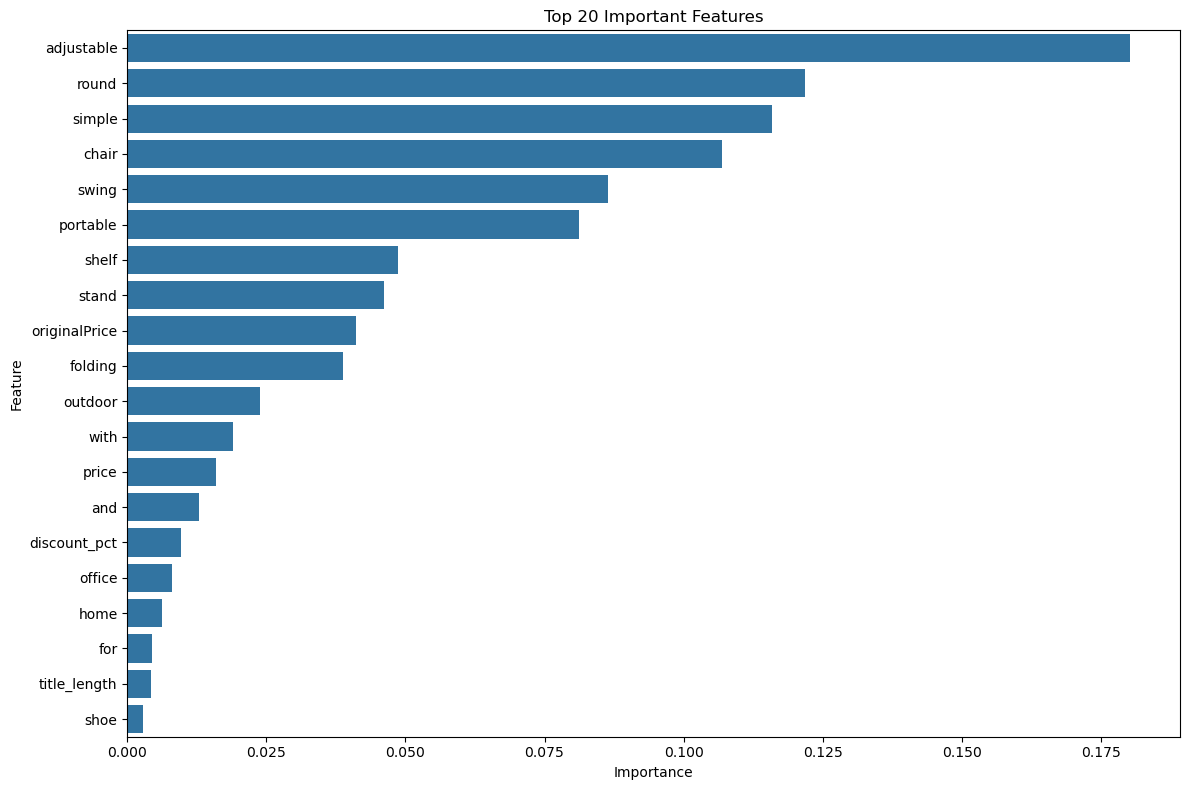


Top 10 Important Features:
          Feature  Importance
5      adjustable    0.180204
70          round    0.121757
81         simple    0.115896
14          chair    0.106896
90          swing    0.086459
65       portable    0.081113
76          shelf    0.048578
85          stand    0.046073
1   originalPrice    0.041156
33        folding    0.038691


In [7]:
## 5. Feature Importance Analysis
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))

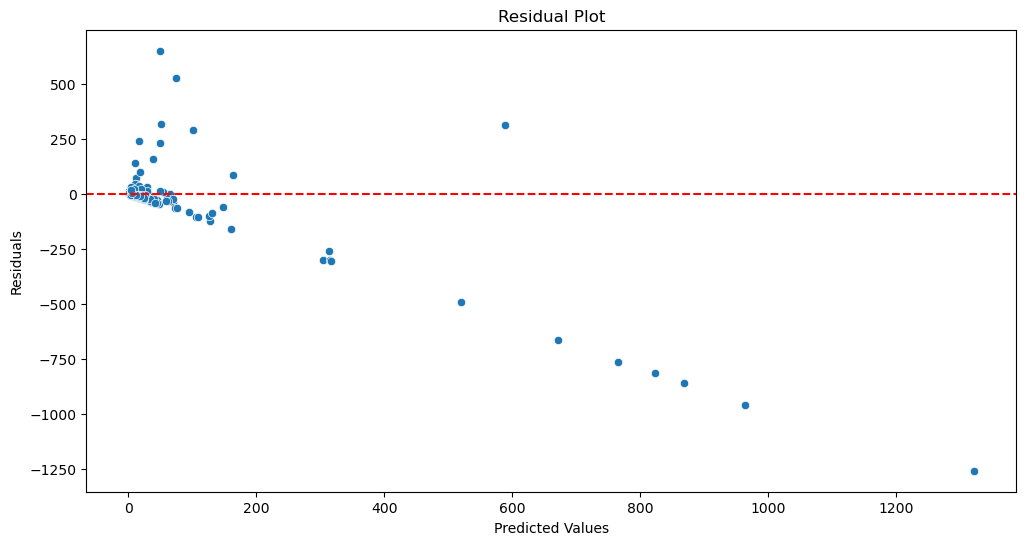

In [8]:
## 6. Residual Analysis
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

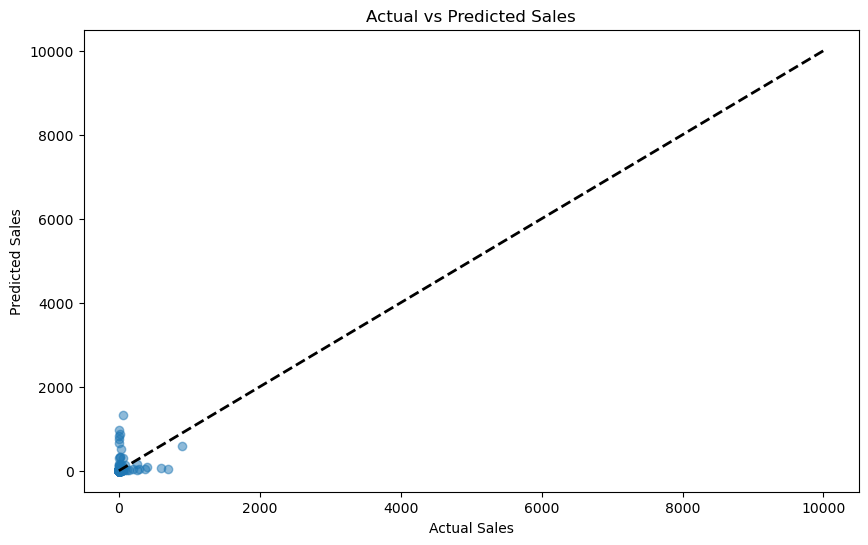

In [9]:
## 7. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()